# Introduction

In this notebook I will share some of the work I've done for [Kaggle's Titanic competition](https://www.kaggle.com/c/titanic).

By doing an exploratory analysis and feature engineering, I aim to build the foundations for a machine learning model that can predict the chances of passengers survival.

# Load data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rc("lines", markeredgewidth=0.5) # This is required beacuse: http://bit.ly/2DEqYXt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from functional import compose
from analysis import *

In [2]:
data_train = pd.read_csv('../data/train.csv')
data_test = pd.read_csv('../data/test.csv')
data_all = pd.concat([data_train, data_test], ignore_index=True)

In [3]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


We can see that the data is composed of 10 feautres as described in Kaggle's [data dictionary](https://www.kaggle.com/c/titanic/data).

We can also notice that Age, Cabin, Embarked and Fare has missing values.

# Feature Analysis

## Pearson correlation

Let's start by plotting the correlation of the features to see how features are related to each other

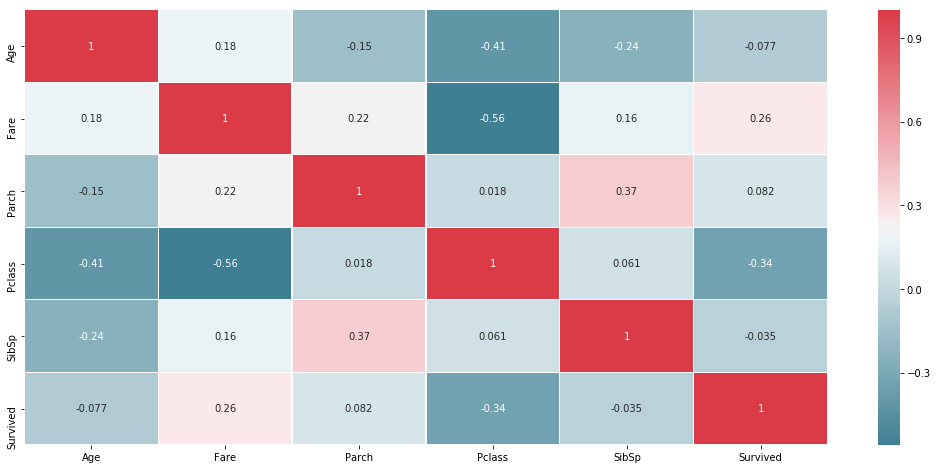

In [4]:
plt.figure(figsize=(18, 8))

corr=data_all.drop('PassengerId', axis='columns').corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,linewidths=0.1,vmax=1.0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), linecolor='white', annot=True)

While we can see that there are not too many features strongly correlated with one another, there are a couple of interesting insights that might worth to dig into.

There's a negative correlation between Survived and Pclass. This would confirm the intuition that 3rd class passengers were less likely to survive.

Aside from Pclass, Survived is correlated with Fare next, so let's take a closer look to that. 

Fare's strongest correlation is with Pclass, and it's a negative correlation. This could be explained arguing that first class passengers would have payed more than third class passengers. Unfortunately this does not help us explain the relationship between Fare and Survived, since the former is a negative and the latter is a possitive correlation. 

On the other hand, could the correlation with Parch and Pchild be significant?

## Groups of people

We could hypothesize that people travelling togheter might help each other, and the chances of survival could be somehow related to that.

We can create think of three different ways to find groups of people:
1. People that belong to the same family are a group
2. Assume that people in the same cabin are part of the same group
3. Assume that poeple with the same ticket are part of the same group

Based on this assumptions, we will create four new features:
1. FamilySize = 1 + Parch + SibSp
2. CabinSize = Number of people in the same cabin
3. TicketSize = Number of people with the same ticket
4. GroupSize = max(FamilySize, CabinSize, TicketSize)

Finally, by plotting the correlation of this new features, we can see that Fare is possitively correlated to them and in turn, that could perhaps explain the correlation between Fare and Survival.

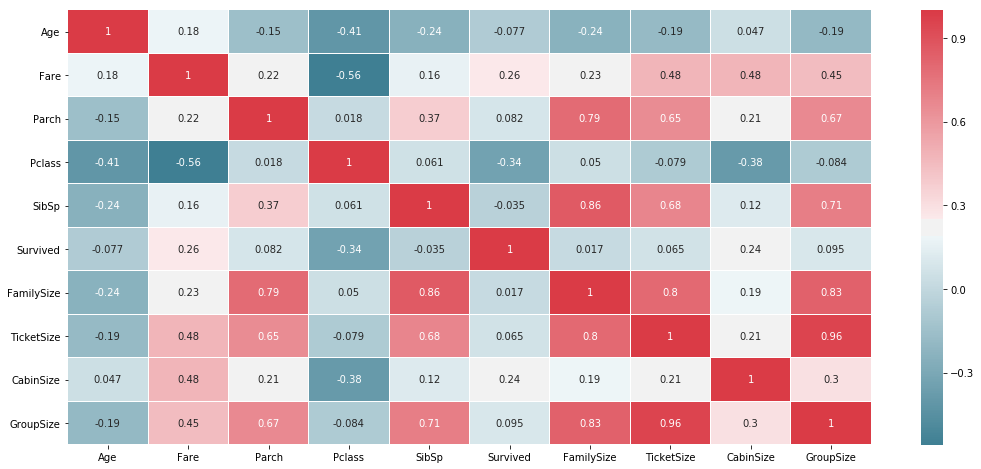

In [5]:
plt.figure(figsize=(18, 8))

group_analysis = compose(add_group_size, add_cabin_size, add_ticket_size, add_family_size)(data_all)
corr=group_analysis.drop('PassengerId', axis='columns').corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=0.1, vmax=1.0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), linecolor='white', annot=True)


# Correlation between Fare and Groups are stronger. Hipothesis: The fare is the price the entire group payed instead of individual price?

## Fare

So we found out that Fare is positively correlated to GroupSize, so perhaps the Fare is not how much a single individual payed, but the aggregated ammount of how much the entire group payed.

So let's calculate the ticket price per individual dividing the fare by the group size.

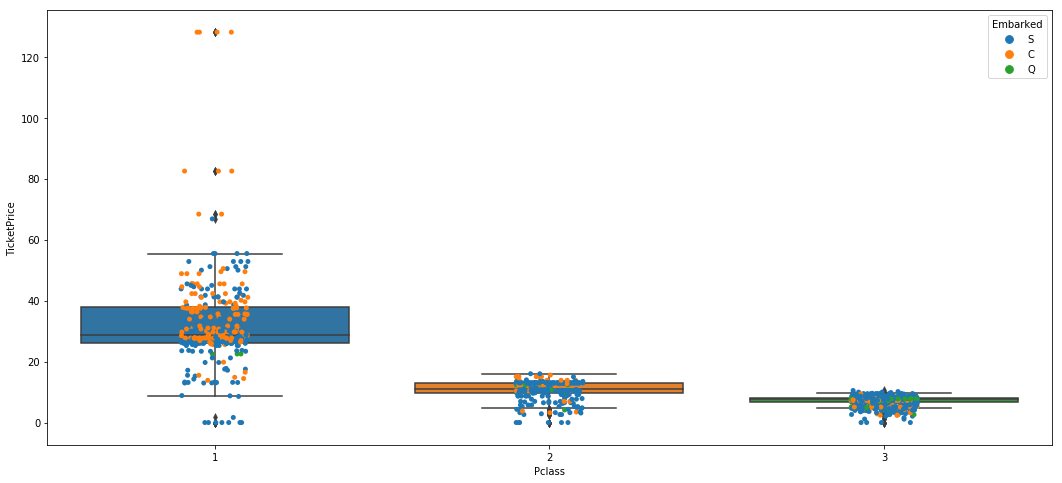

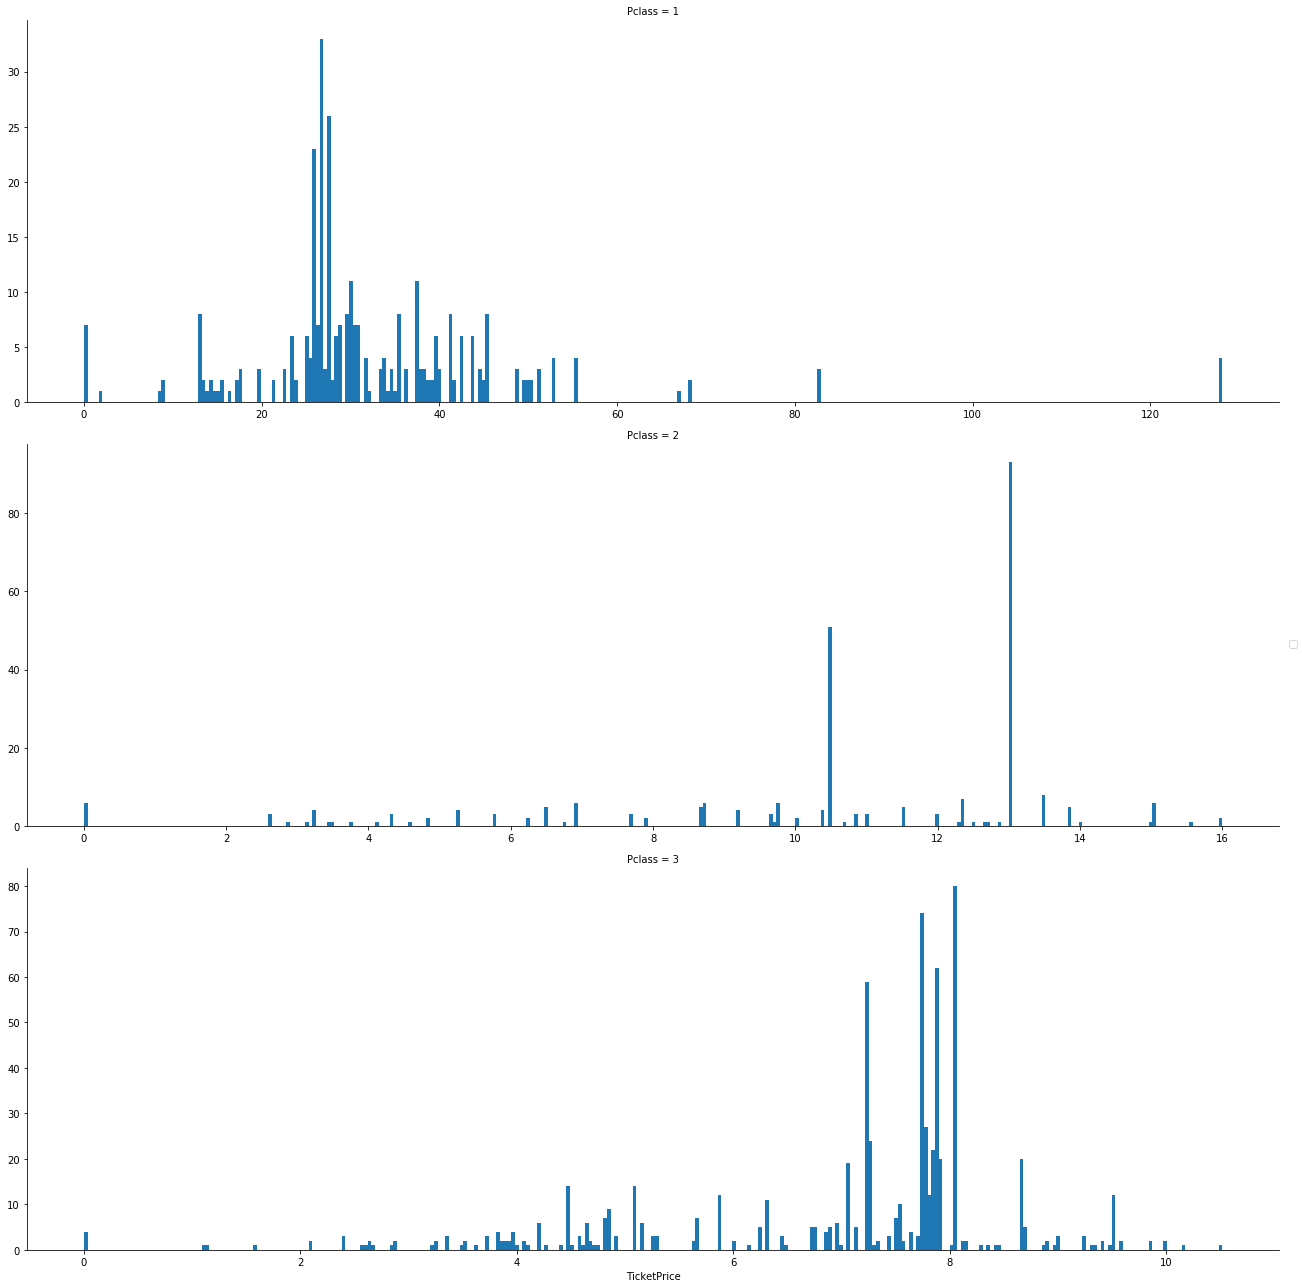

In [6]:
ticket_price = group_analysis.assign(TicketPrice = group_analysis['Fare'] / group_analysis['GroupSize'])[['TicketPrice', 'Pclass', 'Embarked']]

plt.figure(figsize=(18, 8))
sns.boxplot(x="Pclass", y="TicketPrice", data=ticket_price[['TicketPrice', 'Pclass']])
sns.stripplot(x="Pclass", y="TicketPrice", data=ticket_price[['TicketPrice', 'Pclass', 'Embarked']], hue='Embarked', jitter=True, edgecolor="gray")

grid = sns.FacetGrid(ticket_price, row='Pclass', size=6, aspect=3, sharex=False, sharey=False)
grid.map(plt.hist, 'TicketPrice', bins=len(ticket_price['TicketPrice'].unique()))
grid.add_legend()

Looking at the distribution of TicketPrice we can detect some outliers:
* 10 people who payed over 60 for 1st class tickets
* 17 people who traveled for free. According to https://www.encyclopedia-titanica.org/titanic-crew-list/, none of these were part of the 885 crew members

So we can now estimate how much each indivudal payed for the ticket, and use that information to fill in the missing Fare values. We will also remove the outliers by bounding them to the maximum and minumum values.

In [7]:
df = compose(add_group_size, add_cabin_size, add_ticket_size, add_family_size)(data_all)

estimate_ticket_price(df, outlier_low=0, outlier_high=60)

TicketPrice                    
               min      max       mean
Pclass                                
1         1.666667  55.4448  31.144206
2         2.625000  16.0000  10.842984
3         1.110714  10.5167   7.049797

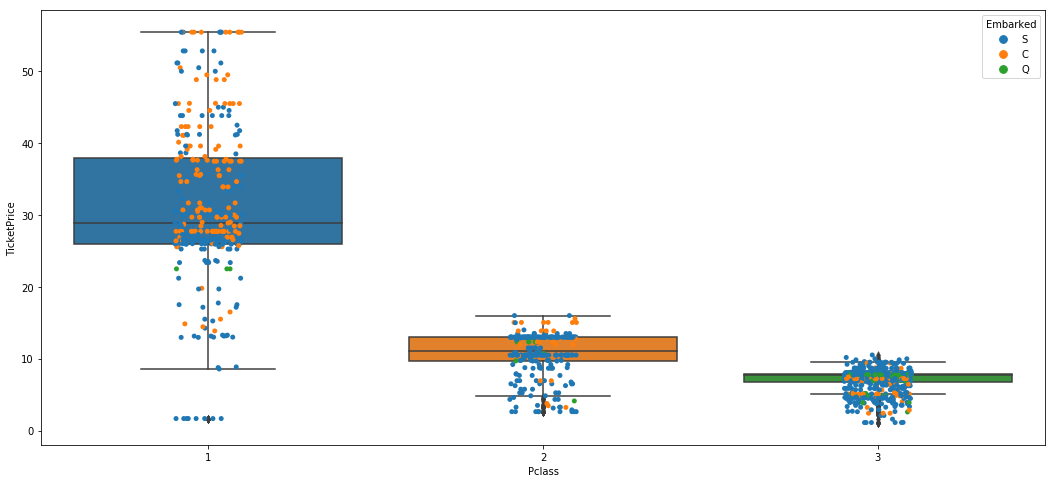

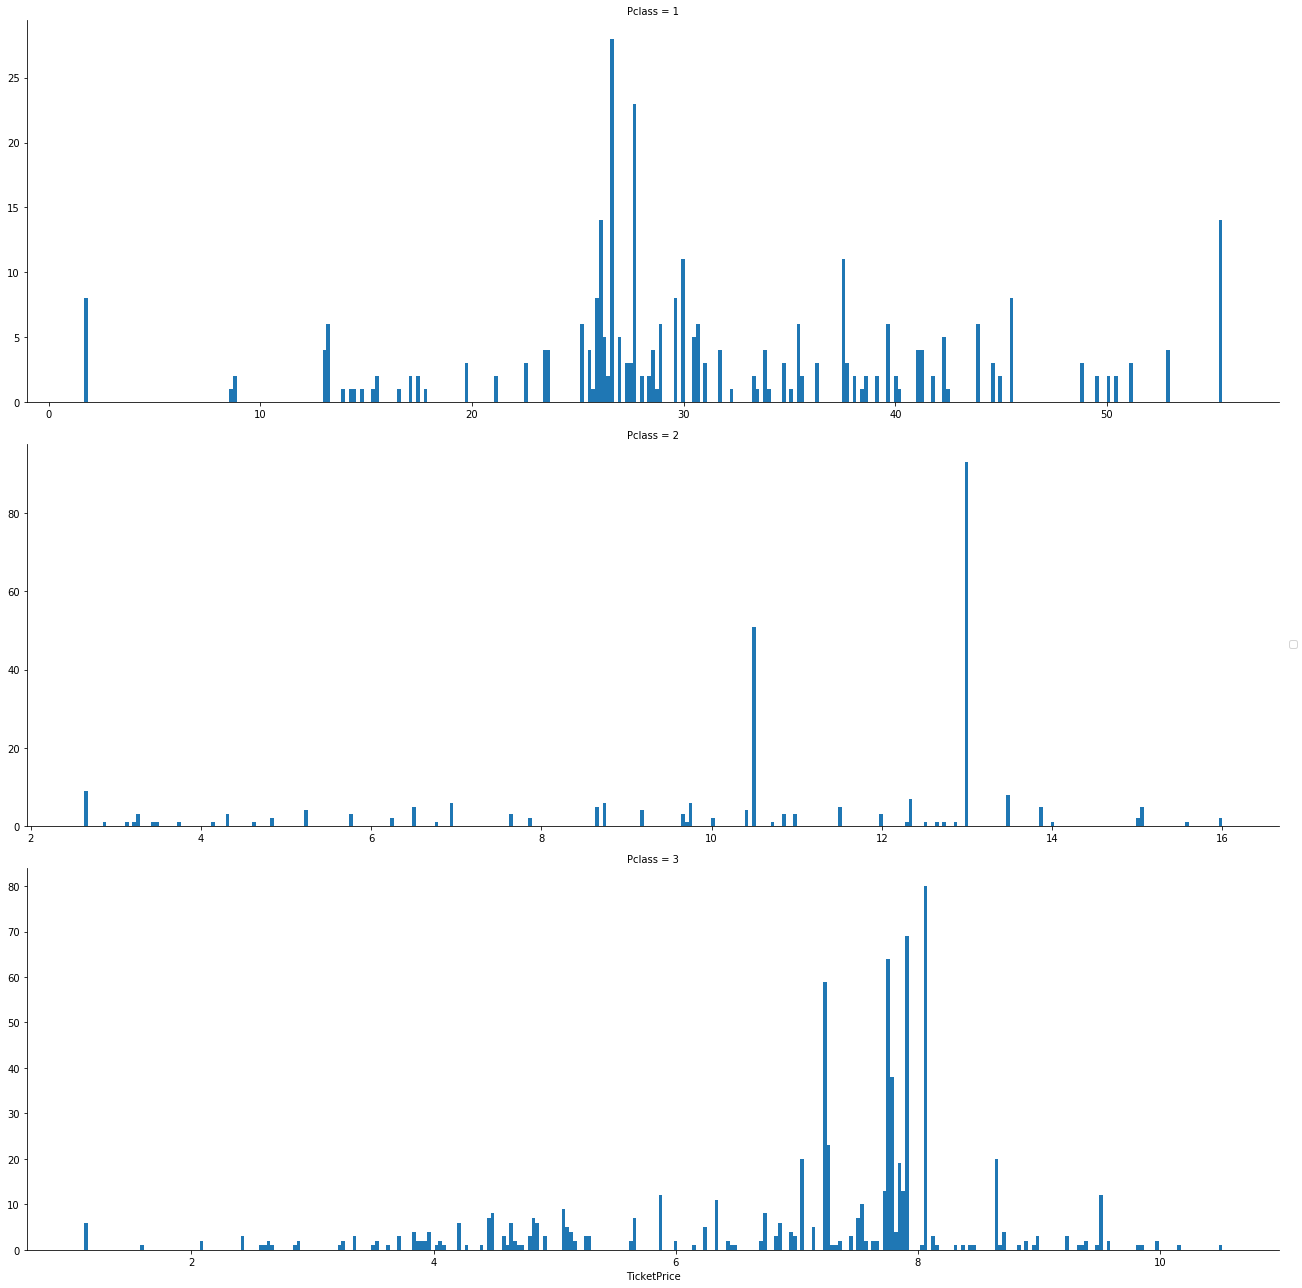

In [8]:
bounded_fare = add_bounded_fare(group_analysis, outlier_low=0, outlier_high=60)
ticket_price = bounded_fare.assign(TicketPrice = bounded_fare['BoundedFare'] / bounded_fare['GroupSize'])[['TicketPrice', 'Pclass', 'Embarked']]

plt.figure(figsize=(18, 8))
sns.boxplot(x="Pclass", y="TicketPrice", data=ticket_price[['TicketPrice', 'Pclass']])
sns.stripplot(x="Pclass", y="TicketPrice", data=ticket_price[['TicketPrice', 'Pclass', 'Embarked']], hue='Embarked', jitter=True, edgecolor="gray")

grid = sns.FacetGrid(ticket_price, row='Pclass', size=6, aspect=3, sharex=False, sharey=False)
grid.map(plt.hist, 'TicketPrice', bins=len(ticket_price['TicketPrice'].unique()))
grid.add_legend()

## Title

If we extract the passenger's title from Name we can see that it's closely related to Sex, the only exception being one female doctor.

We can also notice that some outliers such as _Countess_, _Jonkheer_, _Major_, _Capt_, etc. which are titles only used by few people. We could remove this outliers mapping them into the most commonly used ones, or group them toghether in a new category _Rare_.

We can also notice some interesting patterns in the relationship with Age: _Misses_ are younger than _Mrs_, all _Masters_ are children, etc. So we will leverage this finding by using this new feature to estimate the missing Ages.

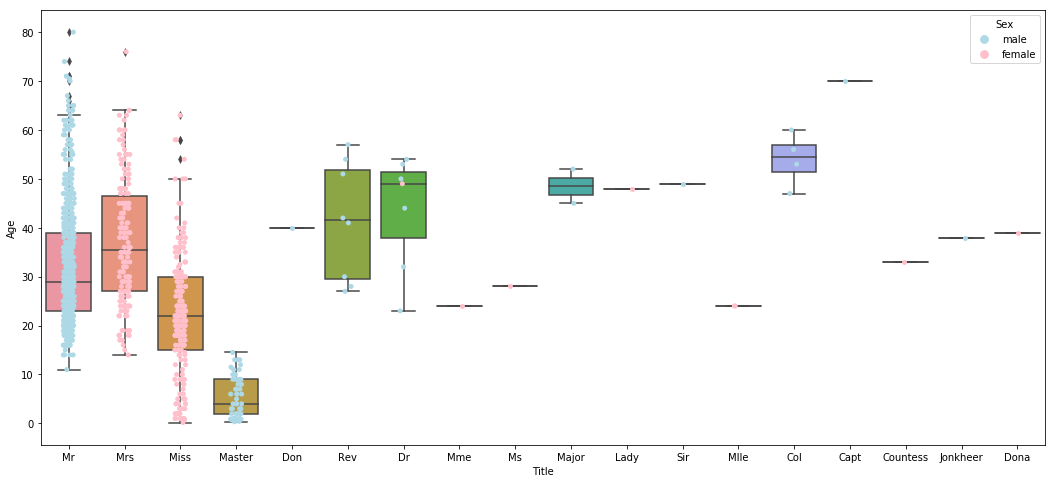

In [9]:
plt.figure(figsize=(18, 8))
sns.boxplot(x="Title", y="Age", data=add_title(data_all)[['Title', 'Age']])
sns.stripplot(x="Title", y="Age", data=add_title(data_all)[['Title', 'Age', 'Sex']], hue='Sex', palette=["lightblue", "pink"], jitter=True, edgecolor="gray")
# Misses are younger than Mrs as expected. Ms is in her twenties and with no spouse on board, so we will consider them Misses
# We can see a pink dot in the doctor category, surrounded by blue dots. This is the only title applicable to both genders on this dataset

In [10]:
add_title(data_all).pivot_table(index=["Title"],values=["Sex"], aggfunc=lambda x: len(x.unique())).transpose()

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1


In [11]:
data_temp = add_title(data_all)
data_all[data_temp.Title == 'Dr']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
245,44.0,C78,Q,90.0000,"Minahan, Dr. William Edward",0,246,1,male,2,0.0,19928
317,54.0,NaN,S,14.0000,"Moraweck, Dr. Ernest",0,318,2,male,0,0.0,29011
398,23.0,NaN,S,10.5000,"Pain, Dr. Alfred",0,399,2,male,0,0.0,244278
632,32.0,B50,C,30.5000,"Stahelin-Maeglin, Dr. Max",0,633,1,male,0,1.0,13214
660,50.0,NaN,S,133.6500,"Frauenthal, Dr. Henry William",0,661,1,male,2,1.0,PC 17611
766,NaN,NaN,C,39.6000,"Brewe, Dr. Arthur Jackson",0,767,1,male,0,0.0,112379
796,49.0,D17,S,25.9292,"Leader, Dr. Alice (Farnham)",0,797,1,female,0,1.0,17465
1184,53.0,A34,S,81.8583,"Dodge, Dr. Washington",1,1185,1,male,1,NaN,33638


## Age and AgeGroup

The missing ages will be filled by grouping passengers by Title, and calculating the mean age for each title.

On top of that, we will also create an AgeGroup feature, partitioning the ages in 8 bins, so each bin will represent a decade.

## Embarked

We will fill the missing enmbarked value with the most frequent value

## SexAndClass

Finally we will combine Sex and Pclass features into a new categorical SexAndClass feature

# Final dataset

We are now ready to put it all together and prepare the data to feed into our prediction model.

In [12]:
prepare_data = compose(
    add_bounded_fare,
    fill_embarked, 
    add_group_size, 
    add_cabin_size, 
    add_ticket_size, 
    add_family_size, 
    add_family_name, 
    add_sex_and_class,
    add_age_group, 
    fill_age, 
    add_title)

data_all_fixed = prepare_data(data_all)

data_train_fixed = data_all_fixed[:len(data_train)]
data_test_fixed = data_all_fixed[len(data_train):]

In [13]:
data_all_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 21 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
AgeGroup       1309 non-null category
Sex_Class      1309 non-null object
FamilyName     1309 non-null object
FamilySize     1309 non-null int64
TicketSize     1309 non-null int64
CabinSize      1309 non-null int32
GroupSize      1309 non-null int64
BoundedFare    1309 non-null float64
dtypes: category(1), float64(4), int32(1), int64(7), object(8)
memory usage: 200.9+ KB


After plotting the correlation of all features we see that some of them are now highly correlated. We will need to work on feature selection and dimensionality reduction while we work on the prediction model.

By plotting the survival rate accross diferent features, we can gain some insight about their importance.

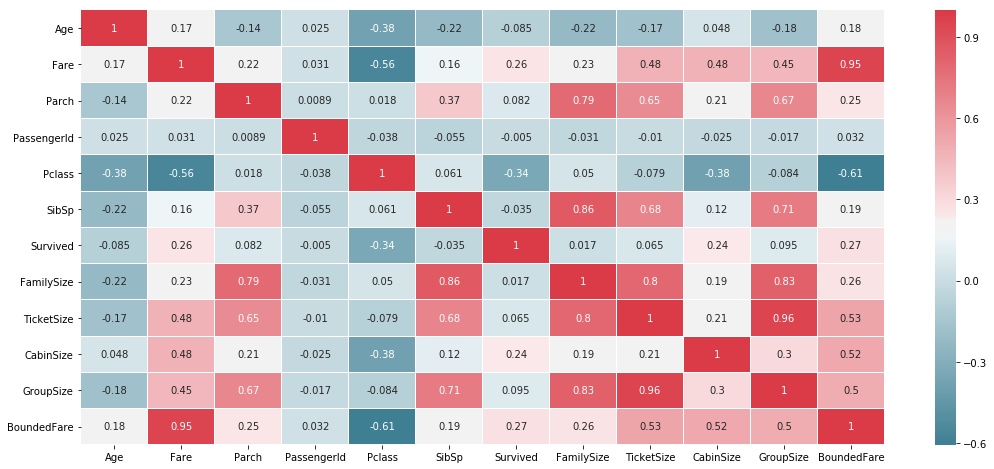

In [14]:
plt.figure(figsize=(18, 8))

corr=data_all_fixed.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=0.1, vmax=1.0, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), linecolor='white', annot=True)

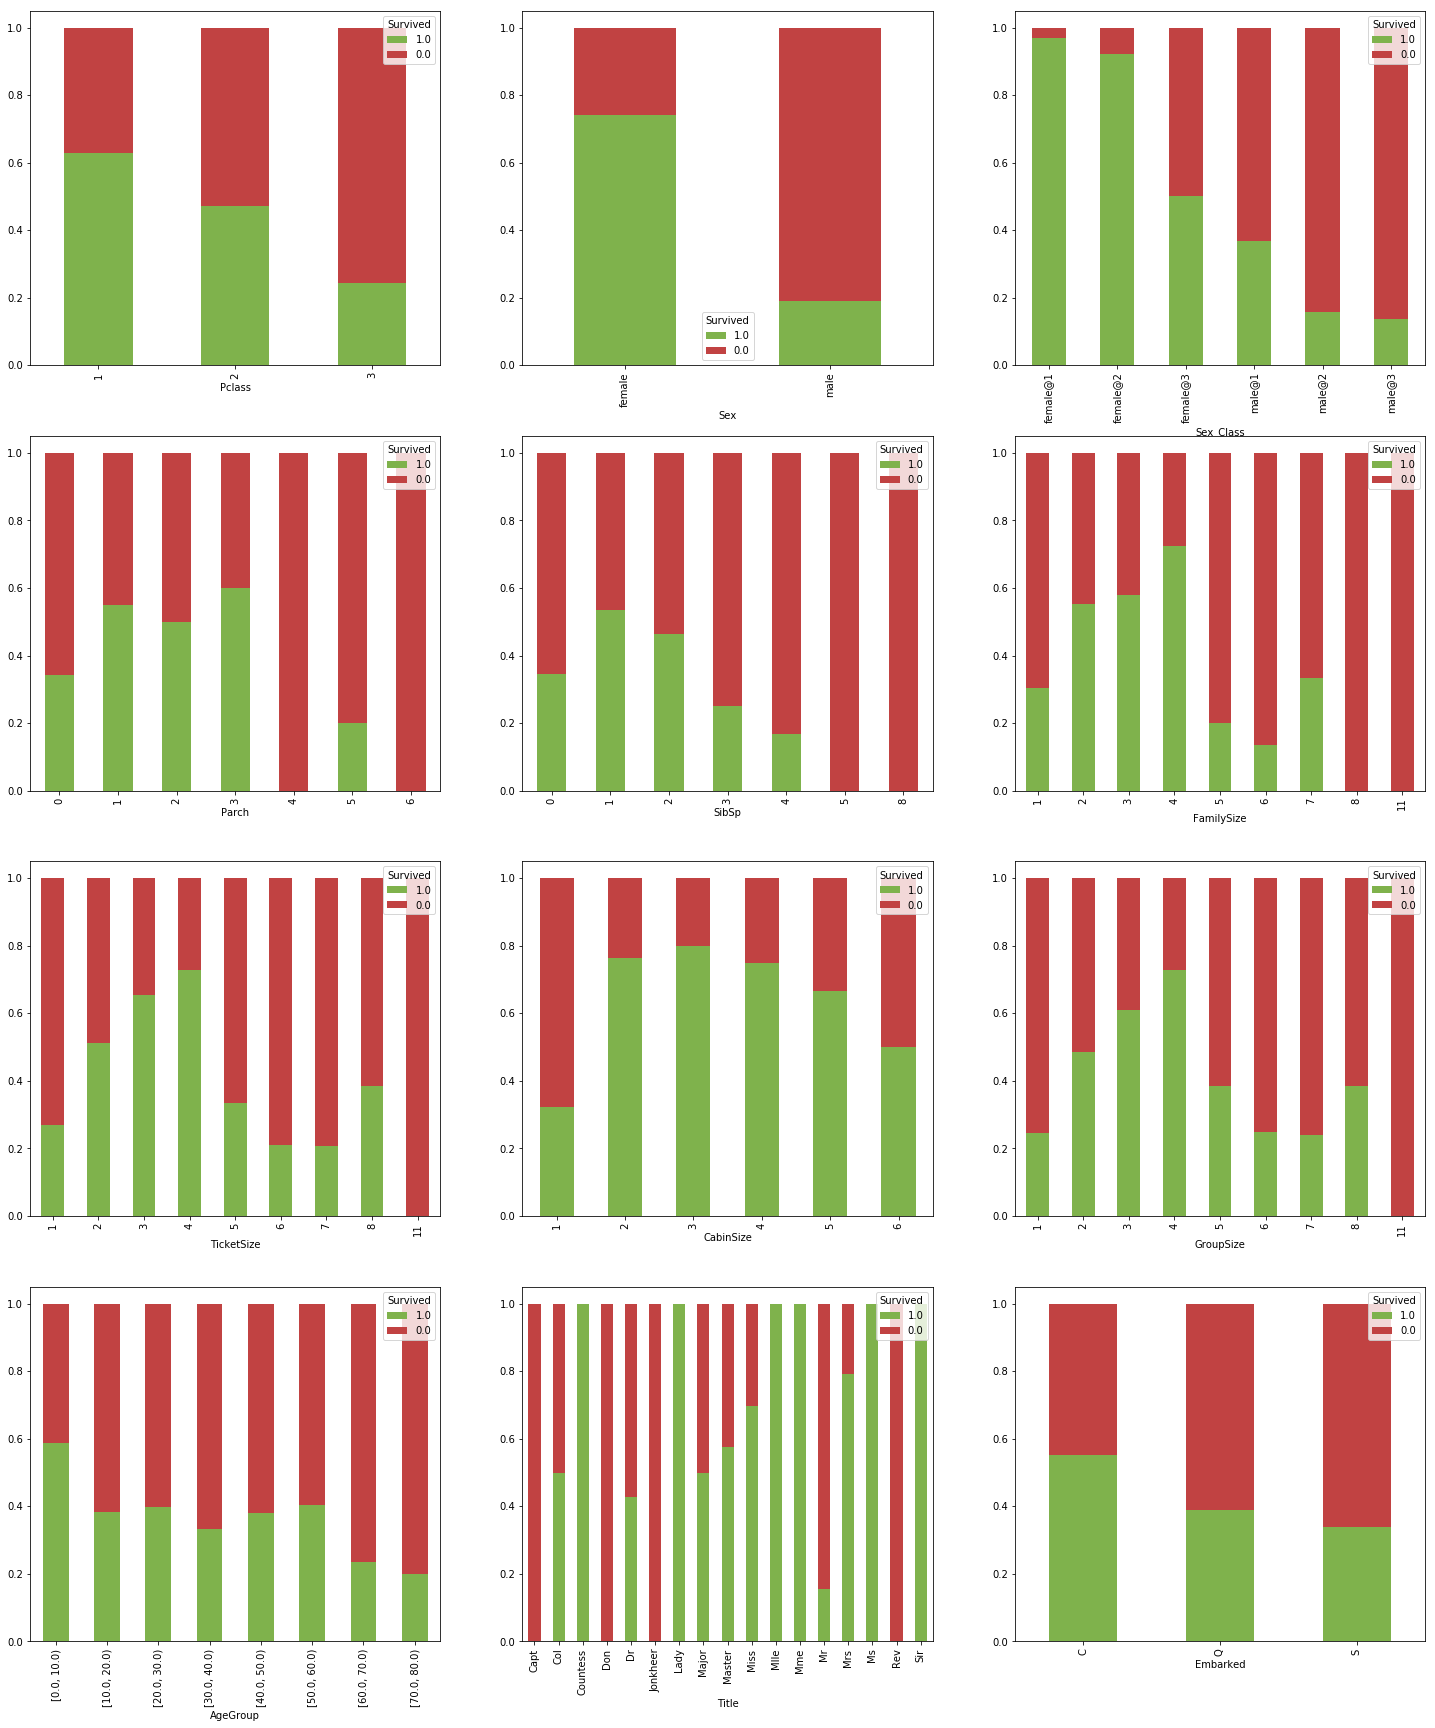

In [15]:
features = ['Pclass' , 'Sex', 'Sex_Class', 'Parch', 'SibSp', 'FamilySize', 'TicketSize', 'CabinSize', 'GroupSize', 'AgeGroup', 'Title', 'Embarked']

ncols=3
_, ax = plt.subplots(nrows=math.ceil(len(features)/ncols), ncols=ncols)
axes = np.ravel(ax)

for feature in features:
  (survival_rate(feature, data_train_fixed)
   .plot(kind='bar', stacked=True, color=['#7FB24C', '#C14242'], figsize=(25,30), ax=axes[features.index(feature)]))